In [1]:
#%history -g -f notebook_file.ipynb

In [2]:
import tensorflow as tf
from Transformer.PredictingNextTransformerEncoder import PredictingNextTransformerEncoder

In [3]:
from Parameters import TrainingParameters, EnviromentParameters
from Controller import TrainingController
from Utils.SaveUtils import load_parameters
import tensorflow as tf
import numpy as np

In [4]:
folder_path = "./SavedModels/%s" % (
    "0.8264_BPI2012WithResource_BaselineLSTMWithResource_2021-06-18 06:11:10.009443" # AOW
)

In [5]:
parameters_json = load_parameters(folder_path=folder_path)
parameters = TrainingParameters(**parameters_json)
tf.random.set_seed(parameters.dataset_split_seed)
np.random.seed(parameters.dataset_split_seed)

In [6]:
trainer = TrainingController(parameters = parameters)


| Running on /job:localhost/replica:0/task:0/device:CPU:0  

| Preprocessed data loaded successfully: ./datasets/preprocessed/BPI_Challenge_2012_with_resource/AOW 


In [7]:
max_trace_length = max([ len(t) for t in list(trainer.dataset.df['trace'])])
vocab_size = len(trainer.dataset.vocab)

In [8]:
#### Prepare model ####
model = PredictingNextTransformerEncoder(
    num_layers=parameters.transformerParameters.num_layers,
    d_model=parameters.transformerParameters.model_dim,
    num_heads=parameters.transformerParameters.num_heads,
    dff=parameters.transformerParameters.feed_forward_dim,
    vocab_size=vocab_size,
    pe_input= max_trace_length * 10,
)

In [9]:
from Transformer.scheduler import CustomSchedule
from Transformer.utils import loss_function, accuracy_function
import time


train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

learning_rate = CustomSchedule(parameters.transformerParameters.model_dim)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
from Transformer.masking import create_predicting_next_mask

In [10]:
def train_step(inp, tar):
  combine_mask = create_predicting_next_mask(inp)

  with tf.GradientTape() as tape:
    predictions, _ = model(inp,True,combine_mask)
    loss = loss_function(tar, predictions)

  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(accuracy_function(tar, predictions))

In [11]:
EPOCHS = 1
step = 0

for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()
    train_accuracy.reset_states()

    # inp -> portuguese, tar -> english
    for train_idxs in trainer.train_dataset:
        step += 1
        caseids, padded_data_traces, lengths, padded_data_resources, batch_amount, padded_target_traces  = trainer.dataset.collate_fn(train_idxs)

        train_step(padded_data_traces, padded_target_traces)

        if step % 10 == 0:
            print(f'Epoch {epoch + 1} Step {step} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

    print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

    print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

Epoch 1 Step 10 Loss 4.5981 Accuracy 0.0418
Epoch 1 Step 20 Loss 4.4998 Accuracy 0.0447
Epoch 1 Step 30 Loss 4.3717 Accuracy 0.0482
Epoch 1 Step 40 Loss 4.2223 Accuracy 0.0537
Epoch 1 Step 50 Loss 4.0599 Accuracy 0.0643
Epoch 1 Step 60 Loss 3.9023 Accuracy 0.0773
Epoch 1 Step 70 Loss 3.7586 Accuracy 0.0917
Epoch 1 Step 80 Loss 3.6282 Accuracy 0.1104
Epoch 1 Loss 3.6039 Accuracy 0.1144
Time taken for 1 epoch: 28.88 secs



In [12]:
########### Get example data from trainer ###########
ordered_test_idx = (list(trainer.test_dataset.unbatch().as_numpy_iterator()))
ordered_test_idx.sort()
print("Test set length: %d" %(len(ordered_test_idx)))

Test set length: 1309


In [13]:
caseids, example_data, example_lengths, example_resources, example_amount, _ = trainer.dataset.collate_fn([ordered_test_idx[5]])
remove_trail_steps = 2
example_idx_trace = np.array([example_data[0][:-remove_trail_steps]])
example_idx_resources = np.array([example_resources[0][:-remove_trail_steps]])

example_vocab_trace = trainer.model.vocab.list_of_index_to_vocab_2d(example_idx_trace)[0]
example_input = tf.constant(example_idx_trace, dtype=tf.int64)
example_resources_input = tf.constant(example_idx_resources)
example_amount_input = tf.constant(example_amount)

In [15]:
trainer.model.vocab.vocab_to_index('<EOS>')

1

In [16]:
def evaluate(trace, max_length=40, eos_id = 1):
    encoder_input = trace
    # as the target is english, the first word to the transformer should be the
    # english start token.

    attentions_in_time_series = []

    for i in range(max_length):
        combined_mask = create_predicting_next_mask(encoder_input)

        # predictions.shape == (batch_size, seq_len, vocab_size)
        predictions, attention_weights = model(encoder_input,
                                                     False,
                                                     combined_mask)

        attentions_in_time_series.append(attention_weights)

        # select the last word from the seq_len dimension
        predictions = predictions[:, -1:, :]  # (batch_size, 1, vocab_size)

        predicted_id = tf.argmax(predictions, axis=-1)

        # concatentate the predicted_id to the output which is given to the decoder
        # as its input.
        encoder_input = tf.concat([encoder_input, predicted_id], axis=-1)

        # return the result if the predicted_id is equal to the end token
        if predicted_id == eos_id:
            break

    # output.shape (1, tokens)

    return encoder_input, attentions_in_time_series

In [17]:
predicted, attentions_in_time_series = evaluate(example_input)

In [18]:
print(trainer.model.vocab.list_of_index_to_vocab_2d(example_input))

[['<SOS>',
  'A_SUBMITTED_COMPLETE',
  'A_PARTLYSUBMITTED_COMPLETE',
  'A_PREACCEPTED_COMPLETE',
  'W_Afhandelen leads_COMPLETE',
  'W_Completeren aanvraag_COMPLETE',
  'A_ACCEPTED_COMPLETE',
  'A_FINALIZED_COMPLETE',
  'O_SELECTED_COMPLETE',
  'O_CREATED_COMPLETE',
  'O_SENT_COMPLETE',
  'W_Completeren aanvraag_COMPLETE',
  'W_Nabellen offertes_COMPLETE',
  'W_Nabellen offertes_COMPLETE',
  'W_Nabellen offertes_COMPLETE',
  'W_Nabellen offertes_COMPLETE',
  'W_Nabellen offertes_COMPLETE',
  'O_SENT_BACK_COMPLETE',
  'W_Nabellen offertes_COMPLETE',
  'W_Valideren aanvraag_COMPLETE',
  'W_Valideren aanvraag_COMPLETE',
  'W_Nabellen incomplete dossiers_COMPLETE',
  'O_CANCELLED_COMPLETE',
  'O_SELECTED_COMPLETE',
  'O_CREATED_COMPLETE',
  'O_SENT_COMPLETE',
  'W_Nabellen incomplete dossiers_COMPLETE',
  'W_Nabellen incomplete dossiers_COMPLETE',
  'W_Nabellen incomplete dossiers_COMPLETE',
  'W_Nabellen incomplete dossiers_COMPLETE',
  'O_SENT_BACK_COMPLETE',
  'W_Nabellen incomplete dos

In [19]:
import matplotlib.pyplot as plt

In [20]:
def plot_attention_head(in_tokens, translated_tokens, attention):
  # The plot is of the attention when a token was generated.
  # The model didn't generate `<START>` in the output. Skip it.
  ax = plt.gca()
  ax.matshow(attention)
  ax.set_xticks(range(len(in_tokens)))
  ax.set_yticks(range(len(translated_tokens)))

  labels = in_tokens
  ax.set_xticklabels(
      labels, rotation=90)

  labels = translated_tokens
  ax.set_yticklabels(labels)

In [21]:
def plot_attention_weights(in_tokens, translated_tokens, layer_of_attention_heads):

  fig = plt.figure(figsize=(60, 20))

  n_l, n_h = layer_of_attention_heads.shape[:2]

  for l, attention_heads in enumerate(layer_of_attention_heads):
    n_h = len(attention_heads)
    for h, head in enumerate(attention_heads):
        ax = fig.add_subplot(n_l, n_h, (l*n_h) + h+1)
        plot_attention_head(in_tokens, translated_tokens, head)
        ax.set_xlabel(f'Layer {l+1} Head {h+1} ')
  plt.tight_layout()
  plt.show()

In [22]:
all_tokens = trainer.model.vocab.list_of_index_to_vocab(predicted.numpy()[0])

In [23]:
def plot_average_attention(in_tokens, translated_tokens, layer_of_attention_heads):
  fig = plt.figure(figsize=(60, 20))

  n_l, n_h = layer_of_attention_heads.shape[:2]

  for l, attention_heads in enumerate(layer_of_attention_heads):
    n_h = len(attention_heads)
    for h, head in enumerate(attention_heads):
        ax = fig.add_subplot(n_l, n_h, (l*n_h) + h+1)
        plot_attention_head(in_tokens, translated_tokens, head)
        ax.set_xlabel(f'Layer {l+1} Head {h+1} ')
  plt.tight_layout()
  plt.show()

In [24]:
tf.reduce_mean(tf.concat(attentions_in_time_series[0], axis = 0)[:,:, -2:-1,:], axis= [0,1])

<tf.Tensor: shape=(1, 35), dtype=float32, numpy=
array([[0.03186664, 0.03025644, 0.02913949, 0.02962656, 0.0265818 ,
        0.02488464, 0.02632874, 0.02978767, 0.03092291, 0.02955683,
        0.03195203, 0.02758458, 0.02889765, 0.02798533, 0.02799965,
        0.02906677, 0.03082168, 0.03110891, 0.03268725, 0.02746629,
        0.02680924, 0.02811904, 0.02668631, 0.02817251, 0.02739965,
        0.02994646, 0.02934843, 0.02982329, 0.03062575, 0.03125417,
        0.03140647, 0.03109623, 0.0320563 , 0.03273429, 0.        ]],
      dtype=float32)>

In [25]:
def plot_average_attention(in_tokens, translated_tokens, layer_of_attention_heads):
  # The plot is of the attention when a token was generated.
  # The model didn't generate `<START>` in the output. Skip it.
  attention = tf.reduce_mean(layer_of_attention_heads, axis= [0,1])
  ax = plt.gca()
  ax.matshow(attention)
  ax.set_xticks(range(len(in_tokens)))
  ax.set_yticks(range(len(translated_tokens)))

  labels = in_tokens
  ax.set_xticklabels(
      labels, rotation=90)
  labels = translated_tokens
  ax.set_yticklabels(labels)

In [26]:
i = 0
trace_length = example_input.shape[1]
plot_attention_weights(all_tokens[i: i+trace_length], [all_tokens[i+1: i+trace_length+1][-1]], tf.concat(attentions_in_time_series[0], axis = 0)[:,:, -2:-1,:])

In [32]:
tf.concat(attentions_in_time_series[2], axis = 0)[:,:, -2:-1,:].shape

TensorShape([4, 8, 1, 37])

In [36]:
all_tokens[:trace_length]

['<SOS>',
 'A_SUBMITTED_COMPLETE',
 'A_PARTLYSUBMITTED_COMPLETE',
 'A_PREACCEPTED_COMPLETE',
 'W_Afhandelen leads_COMPLETE',
 'W_Completeren aanvraag_COMPLETE',
 'A_ACCEPTED_COMPLETE',
 'A_FINALIZED_COMPLETE',
 'O_SELECTED_COMPLETE',
 'O_CREATED_COMPLETE',
 'O_SENT_COMPLETE',
 'W_Completeren aanvraag_COMPLETE',
 'W_Nabellen offertes_COMPLETE',
 'W_Nabellen offertes_COMPLETE',
 'W_Nabellen offertes_COMPLETE',
 'W_Nabellen offertes_COMPLETE',
 'W_Nabellen offertes_COMPLETE',
 'O_SENT_BACK_COMPLETE',
 'W_Nabellen offertes_COMPLETE',
 'W_Valideren aanvraag_COMPLETE',
 'W_Valideren aanvraag_COMPLETE',
 'W_Nabellen incomplete dossiers_COMPLETE',
 'O_CANCELLED_COMPLETE',
 'O_SELECTED_COMPLETE',
 'O_CREATED_COMPLETE',
 'O_SENT_COMPLETE',
 'W_Nabellen incomplete dossiers_COMPLETE',
 'W_Nabellen incomplete dossiers_COMPLETE',
 'W_Nabellen incomplete dossiers_COMPLETE',
 'W_Nabellen incomplete dossiers_COMPLETE',
 'O_SENT_BACK_COMPLETE',
 'W_Nabellen incomplete dossiers_COMPLETE',
 'O_ACCEPTED_CO

In [34]:
i = 20
plot_attention_weights(all_tokens[:i+trace_length], [all_tokens[i+trace_length]], tf.concat(attentions_in_time_series[i], axis = 0)[:,:, -2:-1,:])

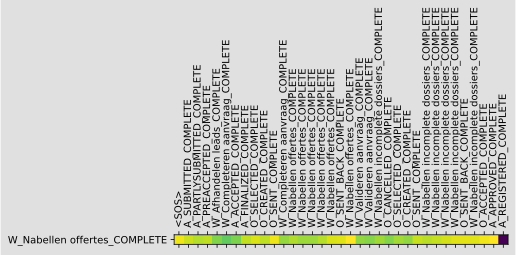

In [28]:
i = 0
trace_length = example_input.shape[1]
plot_average_attention(all_tokens[: i+trace_length], [all_tokens[i+1: i+trace_length+1][-1]], tf.concat(attentions_in_time_series[0], axis = 0)[:,:, -2:-1,:])